In [1]:
# Example of Bayesian parameter estimation using iminuit to find
# posterior mode (MAP) estimators and MCMC for intervals.
# pdf is a mixture of Gaussian (signal) and exponential (background),
# truncated in [xMin,xMax].
# G. Cowan / RHUL Physics / December 2022

import numpy as np
import scipy.stats as stats
from scipy.stats import truncexpon
from scipy.stats import truncnorm
from scipy.stats import chi2
from scipy.special import logsumexp
from scipy.signal import correlate
import iminuit
from iminuit import Minuit
import matplotlib.pyplot as plt
plt.rcParams["font.size"] = 14
print("iminuit version:", iminuit.__version__)  # need 2.x

iminuit version: 2.16.0


In [2]:
# Define pdf
np.random.seed(seed=1234567)        # fix random seed
theta = 0.2                         # fraction of signal
mu = 10.                            # mean of Gaussian
sigma = 2.                          # std. dev. of Gaussian
xi = 5.                             # mean of exponential
xMin = 0.
xMax = 20.

def f(x, par):
    theta   = par[0]
    mu      = par[1]
    sigma   = par[2]
    xi      = par[3]
    fs = stats.truncnorm.pdf(x, a=(xMin-mu)/sigma, b=(xMax-mu)/sigma, loc=mu, scale=sigma)
    fb = stats.truncexpon.pdf(x, b=(xMax-xMin)/xi, loc=xMin, scale=xi)
    return theta*fs + (1-theta)*fb

In [3]:
# Generate data
numVal = 400
xData = np.empty([numVal])
for i in range (numVal):
    r = np.random.uniform();
    if r < theta:
        xData[i] = stats.truncnorm.rvs(a=(xMin-mu)/sigma, b=(xMax-mu)/sigma, loc=mu, scale=sigma)
    else:
        xData[i] = stats.truncexpon.rvs(b=(xMax-xMin)/xi, loc=xMin, scale=xi)

In [4]:
# Specify parameters, initial values, limits, etc.
parin   = np.array([theta, mu, sigma, xi]) # initial values (here = true values)
parname = [r'theta', r'mu', r'sigma', r'xi']
parname_latex = [r'$\theta$', r'$\mu$', r'$\sigma$', r'$\xi$']
parstep = np.array([0.1, 1., 1., 1.])      # initial step sizes for iminuit
parfix  = [False, False, False, False]     # change these to fix/free parameters
numFreePar = sum(1 for i in parfix if parfix[i] == False)
parlim  = [(0.,1.), (None, None), (0., None), (0., None)]    # set limits

In [5]:
# Negative log-likelihood
def negLogL(par):
    fx = f(xData, par)
    return -np.sum(np.log(fx))

# Prior pdf
def prior(par):
    theta    = par[0]
    mu       = par[1]
    sigma    = par[2]
    xi       = par[3]
    pi_theta = 1. if theta >= 0. and theta <= 1. else 0.
    pi_mu    = 1. if mu >= 0. else 0.
    pi_sigma = 1. if sigma > 0. else 0.
    pi_xi    = 1. if xi > 0. else 0.
    piArr = np.array([pi_theta, pi_mu, pi_sigma, pi_xi])
    pi = np.product(piArr[np.array(parfix) == False])   # exclude fixed par
    return pi
    
# Negative log of posterior pdf
def negLogPost(par):
    return negLogL(par) - np.log(prior(par))

In [6]:
# Find maximum of posterior and its covariance
m = Minuit(negLogPost, parin, name=parname)
m.errors = parstep
m.fixed = parfix
m.limits = parlim
m.errordef = 0.5                          # errors from lnL = lnLmax - 0.5
m.migrad()                                # minimize -logPost
MAP = m.values                            # posterior mode
sigmaMAP = m.errors                       # standard deviations
cov = m.covariance                        # covariance matrix
rho = m.covariance.correlation()          # correlation coeffs.
    
print(r"par index, name, MAP estimate, standard deviation:")
for i in range(m.npar):
    if not m.fixed[i]:
        print("{:4d}".format(i), "{:<10s}".format(m.parameters[i]), " = ",
         "{:.6f}".format(MAP[i]), " +/- ", "{:.6f}".format(sigmaMAP[i]))

par index, name, MAP estimate, standard deviation:
   0 theta       =  0.197936  +/-  0.057880
   1 mu          =  9.309286  +/-  0.555300
   2 sigma       =  2.347174  +/-  0.509533
   3 xi          =  5.054644  +/-  0.534132


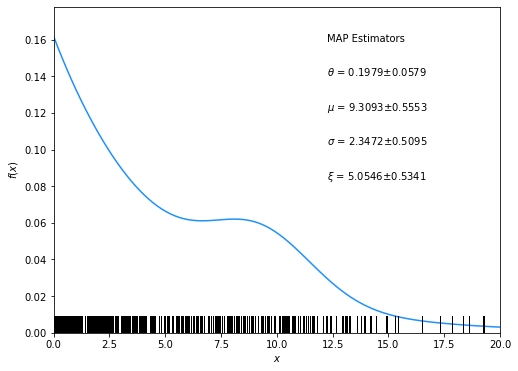

In [7]:
# Plot fitted pdf (MAP estimators)
yMin = 0.
yMax = f(0., MAP)*1.1
fig = plt.figure(figsize=(8,6))
xCurve = np.linspace(xMin, xMax, 100)
yCurve = f(xCurve, MAP)
plt.plot(xCurve, yCurve, color='dodgerblue')
plt.xlabel(r'$x$')
plt.ylabel(r'$f(x)$')
y_fitval = 0.8
delta_y_fitval = 0.08
plt.figtext(0.6, y_fitval, 'MAP Estimators')
for i in range(len(parin)):
    y_fitval -= delta_y_fitval
    if not parfix[i]:
        plt.figtext(0.6, y_fitval, parname_latex[i] + ' = ' + f'{MAP[i]:.4f}' + r'$\pm$' + f'{sigmaMAP[i]:.4f}')

# Add data as tick marks
tick_height = 0.05*(yMax - yMin)
xvals = [xData, xData]
yvals = [np.zeros_like(xData), tick_height * np.ones_like(xData)]
plt.plot(xvals, yvals, color='black', linewidth=1)
plt.xlim(xMin, xMax)
plt.ylim(yMin, yMax)
plt.show()

In [8]:
# Set up MCMC
# see J. Rosenthal, http://probability.ca/jeff/ftpdir/galinart.pdf
scale_prop = 2.38**2/numFreePar      # or adjust to minimize acf
cov_prop = scale_prop*cov
print('posterior covariance = ')
print(cov)
print('proposal covariance = ')
print(cov_prop)

posterior covariance = 
┌───────┬─────────────────────────────────┐
│       │   theta      mu   sigma      xi │
├───────┼─────────────────────────────────┤
│ theta │ 0.00337 -0.0118  0.0197 -0.0208 │
│    mu │ -0.0118   0.308  -0.114  0.0137 │
│ sigma │  0.0197  -0.114    0.26  -0.124 │
│    xi │ -0.0208  0.0137  -0.124   0.285 │
└───────┴─────────────────────────────────┘
proposal covariance = 
┌───────┬─────────────────────────────────┐
│       │   theta      mu   sigma      xi │
├───────┼─────────────────────────────────┤
│ theta │ 0.00478 -0.0167  0.0279 -0.0294 │
│    mu │ -0.0167   0.437  -0.162  0.0193 │
│ sigma │  0.0279  -0.162   0.369  -0.176 │
│    xi │ -0.0294  0.0193  -0.176   0.404 │
└───────┴─────────────────────────────────┘


In [9]:
# Iterate with Metropolis-Hastings algorithm
chain = [np.array(MAP)]         # start point is MAP estimate
numIterate = 10000
numBurn = 100
numAccept = 0
print("Start MCMC iterations: ", end="")
while len(chain) < numIterate:
    par = chain[-1]
    log_post = -negLogL(par) + np.log(prior(par))
    par_prop = np.random.multivariate_normal(par, cov_prop)
    if prior(par_prop) <= 0:
        chain.append(chain[-1])    # never accept if prob<=0.
    else:
        log_post_prop = -negLogL(par_prop) + np.log(prior(par_prop))
        alpha = np.exp(log_post_prop - log_post)
        u = np.random.uniform(0, 1)
        if u <= alpha:
            chain.append(par_prop)
            numAccept += 1
        else:
            chain.append(chain[-1])
        if len(chain)%(numIterate/100) == 0:
            print(".", end="", flush=True)
chain = np.array(chain)
print('\n MCMC acceptance fraction = ', numAccept/numIterate)

Start MCMC iterations: ...............................................................................................
 MCMC acceptance fraction =  0.3737


In [ ]:
# Show trace plots
fig, axes = plt.subplots(sharex=True, nrows=4, figsize=(8,6))
plt.xlim(0, numIterate)
for i, (ax, label) in enumerate(zip(axes, parname_latex)):
    ax.plot(chain[:, i], color="dodgerblue")
    ax.axvline(numBurn, color="orange")
    ax.set_ylabel(label)
axes[-1].set_xlabel("iteration number")
fig.tight_layout()
plt.show()

In [ ]:
# Show marginal distributions
fig, axes = plt.subplots(nrows=4, figsize=(8,6))
for i, (ax, label, sim) in enumerate(zip(axes, parname_latex, np.array(MAP))):
    ax.hist(chain[numBurn:, i], bins=50, density=True, color="dodgerblue")
    ax.set(xlabel=label, ylabel="pdf")
    ax.axvline(sim, color="orange")
fig.tight_layout(pad=0.3)
plt.show()

In [ ]:
# Find autocorrelation and plot
var = chain[numBurn:,].var(axis=0)
x   = chain[numBurn:,] - chain[numBurn:,].mean(axis=0)
max_lag = 200
N   = len(x[:,0])
acf = np.zeros(shape=[max_lag, len(chain[0])])
for i in range(len(chain[0])):
    if var[i] > 0:
        acf[:,i] = np.correlate(x[:,i], x[:,i], mode='full')[N-1:N-1+max_lag]
        acf[:,i] /= (var[i]*N)
    
fig, axes = plt.subplots(sharex=True, nrows=4, figsize=(8,6))
for i, (ax, label) in enumerate(zip(axes, parname_latex)):
    ax.plot(acf[:,i], color="dodgerblue")
    ax.set_ylabel('ACF[' + label + ']')
    ax.set_yticks([0., 0.5, 1.])
    ax.grid()
axes[-1].set_xlabel("lag")
plt.xlim(0, max_lag)
plt.subplots_adjust(left=0.15, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
plt.show()

In [ ]:
# Functions for computing intervals
# input:  values = numpy array with MCMC chain, e.g., chain[:,0]
#         CL = credibility level, e.g., 0.683

# Central credible interval
def cc_interval(values, CL):
    alpha = np.array([(1.-CL)/2., (1.+CL)/2.])
    return np.quantile(values, alpha)

# Highest Probability Density (HPD) interval from MCMC chain
def HPD_interval(values, CL):
    sorted = np.sort(np.copy(values))
    nPoints = len(values)
    nCovered = np.floor(0.683 * nPoints).astype(int)
    intWidth = sorted[nCovered:] - sorted[:nPoints-nCovered]
    minWidth = np.argmin(intWidth)
    hpdLo = sorted[minWidth]
    hpdHi = sorted[minWidth+nCovered]
    return np.array([hpdLo, hpdHi])